# Вспомогательный код

**Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU.**

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Блок кода для визуализации процесса обучения модели:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Чтобы результаты экспериментов воспроизводились, зафиксируем случайные состояния

In [ ]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

# Задание 1. Создание полносвязной сети

1. Создайте двух-трех-слойную* полносвязную нейронную сеть средствами PyTorch.
2. Дополните недостающий код для обучения.
3. Обучите нейросеть на CIFAR-10.
4. Посмотрите график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязных слоев используйте класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear).

*Рекомендуется использовать скрытый слой со 128 нейронами.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import torchvision
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

Загрузим датасет с помощью средств PyTorch.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

train_data, val_data = random_split(train_data, lengths=[40000, 10000])
print(train_data[1][0].shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])


В обучающей выборке CIFAR-10 содержится 50&nbsp;000 изображений. При помощи функции [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) из модуля `torch.utils.data` мы взяли 40&nbsp;000 для обучения и 10&nbsp;000 для валидации.

Также обратите внимание, что сумма значений в параметре `lengths` функции `random_split` должна в точности равняться количеству элементов в датасете, который она разделяет.

Опишите структуру сети: полносвязные слои + [функции активации](https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity) на ваш выбор.

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(32 * 32*3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)

        return logits

**Блок обучения.**

Обратите внимание на то, что в PyTorch моделях не используется метод fit, как в sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим `batch_size` и создадим два DataLoader-а для обучающей и валидационной выборок

In [ ]:
batch_size = 256

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

Функцию для подсчёта точности возьмем из библиотеки [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html):

In [ ]:
score_function = torchmetrics.Accuracy(task="multiclass", num_classes=10)

**Цикл обучения и валидации.**

Определим функции `train_loop` и `val_loop`. Допишите недостающий код. Пользуйтесь материалом лекции.


In [ ]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred =  model(imgs.to(device))# Your code here
        loss =  criterion(pred, labels.to(device))# Your code here

        # Optimization
        # Nullify gradients, do a backward and do an optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # End of your code

        train_loss += loss.detach().item()

        # accumulating predictions and true labels to calculate score function
        score_function.update(pred.cpu(), labels)

    train_loss /= num_batches

    train_score = score_function.compute().item()
    score_function.reset()

    return train_loss, train_score

In [ ]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred =  model(imgs.to(device))# Your code here
            loss =  criterion(pred, labels.to(device))# Your code here

            val_loss += loss.item()

            # accumulating predictions and true labels to calculate score function
            score_function.update(pred.cpu(), labels)

    val_loss /= num_batches

    val_score = score_function.compute().item()
    score_function.reset()

    return val_loss, val_score

Дополните функцию `train` вызовом `train_loop` и `val_loop` внутри цикла по эпохам

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score = train_loop(train_loader, model, criterion, optimizer, score_function, device)# Your code here


        val_loss, val_score =  val_loop(val_loader, model, criterion, score_function, device)# Your code here

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

Создание экземпляра модели, определение оптимизатора, функции потерь, и собственно запуск обучения.

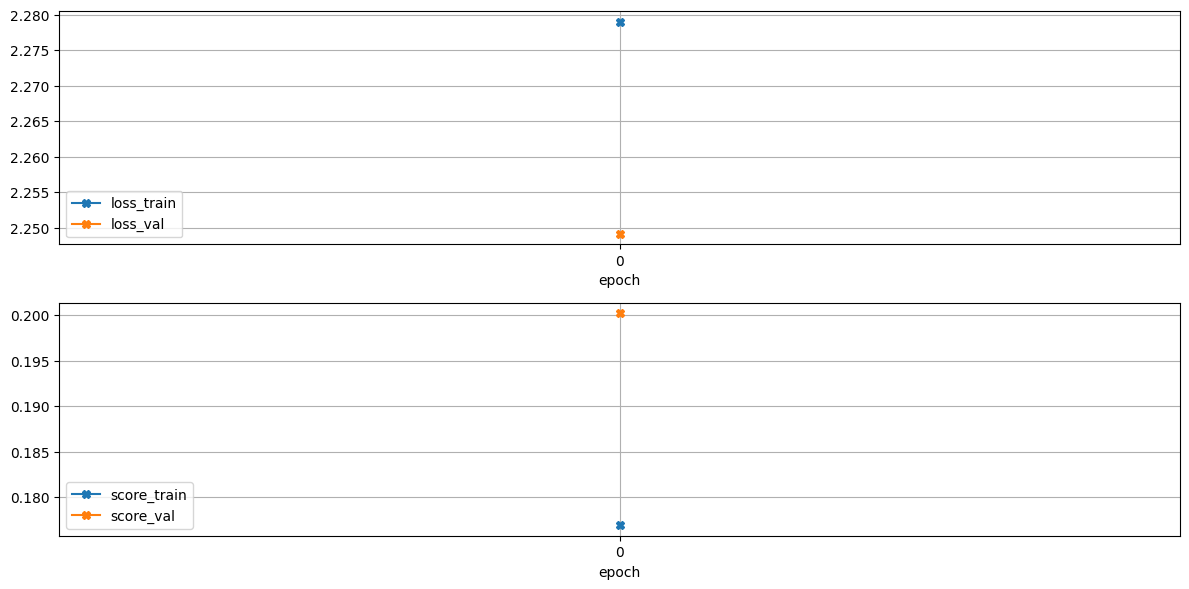

KeyboardInterrupt: 

In [ ]:
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
)

Функция `train` возвращает объект `ProgressPlotter`, который имеет атрибут `.history_dict` — словарь, в котором хранится история обучения модели: значение функции потерь и точности на обучающих и валидационных данных по эпохам.

По ключу `score_val` можно извлечь из словаря значения точности на валидационных данных по эпохам и вывести итоговую точность модели, достигнутую на последней (`-1`-й) эпохе.

In [ ]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.44


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_1_task_ex05.png" width="800">

# Задание 2. Нормализация данных

Стандартизируйте данные и обучите модель на стандартизованных данных.

* Подсчитайте среднее значение и стандартное отклонение по обучающей выборке для каждого из 3-х цветовых каналов
 * Сделайте это с помощью встроенных в PyTorch или NumPy функций
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`[🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html))
* Оцените влияние нормировки данных на точность обучения (сравните результаты обучения на сырых данных в задании №1 и на стандартизованных).

Посмотрим на размерность тензора с обучающими данными

In [ ]:
raw_train_data = train_data.dataset.data[train_data.indices]

print(type(raw_train_data))
print(raw_train_data.shape)

<class 'numpy.ndarray'>
(40000, 32, 32, 3)


Вычислите средние и стандартные отклонения **по каждому из трех цветовых каналов** для обучающих данных.

Каждый канал изображения стандартизуется независимо. Поэтому каждый из объектов `cifar10_mean` и `cifar10_std` должен представлять из себя последовательность (`list` / `np.ndarray` / `torch.Tensor`) длиной в количество каналов.

Также не забудьте, что `Normalize` будет применяться после `ToTensor` и поэтому средние и стандартные отклонения должны быть отмасштабированы в $[0,1]$.

In [ ]:
import torch


raw_train_data_tensor = torch.from_numpy(raw_train_data)
mean = torch.mean(raw_train_data_tensor.double(), dim = [0, 1, 2])
std = torch.std(raw_train_data_tensor.double(), dim = [0, 1, 2])

print(f"Mean: {mean}, Std: {std}")

mean /= 255
std /= 255
mean, std
#print(f"Scaled mean = {mean:.2f}, std = {std:.2f}")


Mean: tensor([125.2684, 122.9835, 113.9732], dtype=torch.float64), Std: tensor([63.0285, 62.0959, 66.6953], dtype=torch.float64)


(tensor([0.4912, 0.4823, 0.4470], dtype=torch.float64),
 tensor([0.2472, 0.2435, 0.2616], dtype=torch.float64))

Создайте трансформацию, которая включает в себя нормализацию, и подмените трансформацию в обучающем Dataset-е на новую.

**Внимание! Неочевидная особенность!**

Атрибут `.transform` необходимо переопределить не у объектов `train_data` и `val_data`, а у объекта `train_data.dataset`, из которого `train_data` и `val_data` были случайно отобраны с помощью функции `random_split` в задании №1.

Функция `random_split` возвращает объекты класса `Subset`, которые не имеют своих трансформаций, а используют трансформации, определенные родительском в `Dataset`-е.

In [ ]:
from torchvision import transforms

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

train_data.dataset.transform = transform_with_normalize
test_data.transform = transform_with_normalize

Снова создайте экземпляр модели, определите оптимизатор и функцию потерь, и вызовите функцию для обучения (можно скопировать код из задания №1).

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(32 * 32*3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)

        return logits


Выведите итоговую точность на валидационных данных.

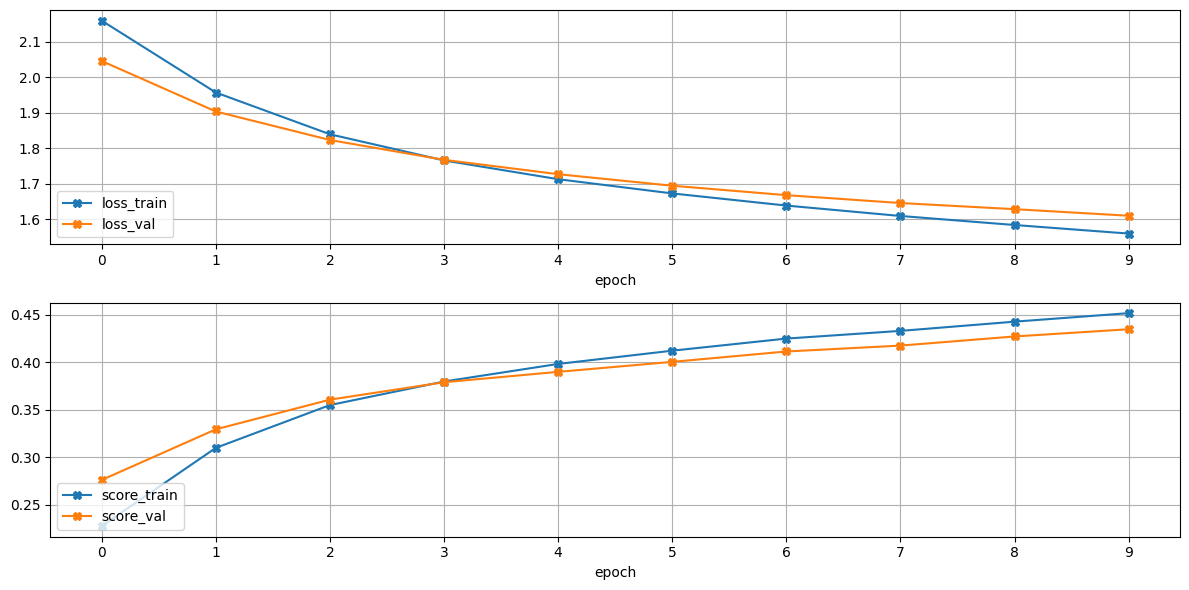

Accuracy 0.43


In [ ]:
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
)

accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Сохраним контрольную точку: обученную модель, состояние оптимизатора и прогресс обучения для следующего задания.

In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'progress_plotter': pp,},
            f = "checkpoint_task2.pth")

## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_2_task_ex05.png" width="800">

# Задание 3. Продолжение обучения из контрольной точки

По результатам предыдущего задания видно, что если модель продолжить обучать еще несколько эпох, то качество может дополнительно улучшиться.

В этом задании вам необходимо:
1. Загрузить контрольную точку, содержащую обученную модель, состояние оптимизатора и прогресс обучения из задания №2.
2. Продолжите обучение модели в течение еще 25 эпох.
3. Вывести суммарные графики обучения, содержащие информацию о предыдушем прогрессе и о результате дообучения.
4. Оцените качество модели на тестовых данных (обратите внимание, что в предыдущих заданиях мы не использовали тестовые данные).



Загрузим контрольную точку, которую мы сохранили в задании №2 и посмотрим, что в ней хранится:

In [ ]:
checkpoint = torch.load("checkpoint_task2.pth")

print(f"Type of checkpoint: {type(checkpoint)}")
print(f"checkpoint keys: {checkpoint.keys()}")

Type of checkpoint: <class 'dict'>
checkpoint keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'progress_plotter'])


Создайте новую модель класса `FCNet` и новый оптимизатор `torch.optim.SGD`.
Загрузите из контрольной точки состояние модели и состояние оптимизатора в созданные объекты с помощью метода `load_state_dict`.

In [ ]:
model = FCNet().to(device) # Your code here
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)# Your code here

model.load_state_dict(torch.load('checkpoint_task2.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('checkpoint_task2.pth')['optimizer_state_dict'])

model.to(device)

# Your code here
# model.load_state_dict(...)
# optimizer.load_state_dict(...)

FCNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Продолжите обучение модели еще в течение 25 эпох. Так как мы загрузили в модель состояние, в котором она уже была сколько-то обучена, то вызов кода обучения просто продолжит обучение.

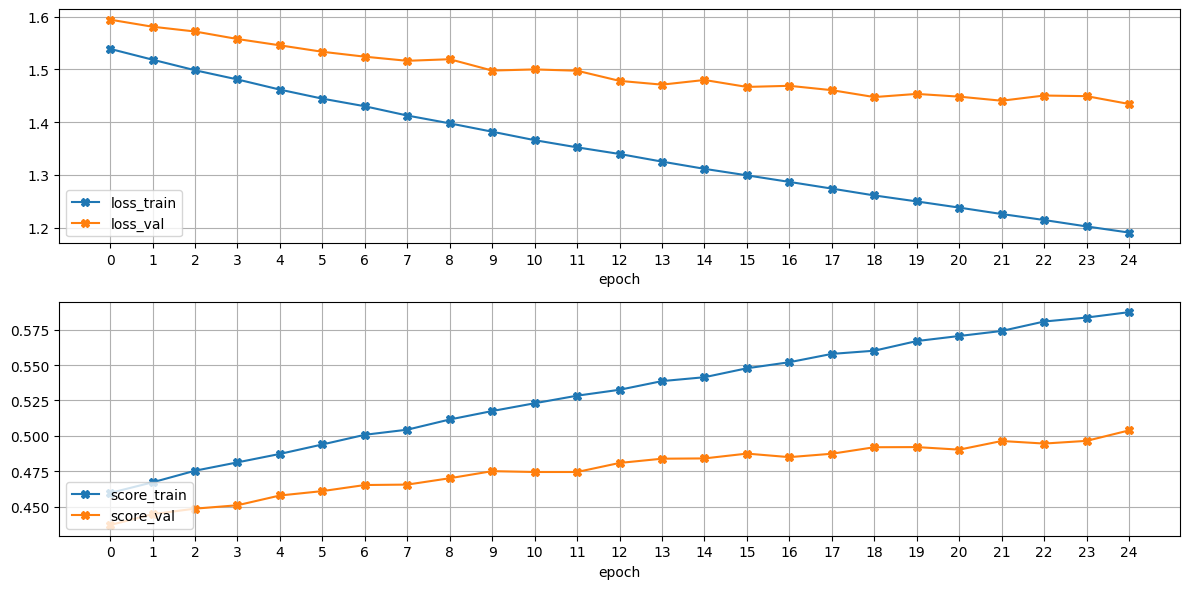

Accuracy 0.50


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=25,
)

accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Выведите итоговую точность на валидационных данных.

In [ ]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.50


Выше выведены графики только процесса дообучения.

Для построения суммарного графика процесса обучения загрузите из контрольной точки `progress_plotter`:

In [ ]:
checkpoint['progress_plotter']

In [ ]:
pp_old =  checkpoint['progress_plotter']

print(f"pp_old.history_dict keys: {pp_old.history_dict.keys()}")
print(f'Type of pp_old.history_dict["loss_train"]: {type(pp_old.history_dict["loss_train"])}')



pp_old.history_dict keys: dict_keys(['loss_train', 'score_train', 'loss_val', 'score_val'])
Type of pp_old.history_dict["loss_train"]: <class 'list'>


Значениями (values) в словаре `pp_old.history_dict` являются списки.
По каждому ключу в словаре `pp_old.history_dict` добавьте в соответствующий список значения, полученные в результате дообучения.

In [ ]:
for key in pp_old.history_dict.keys():
    pp_old.history_dict[key] += pp.history_dict[key]
    # Your code here

Отобразим итоговые графики:

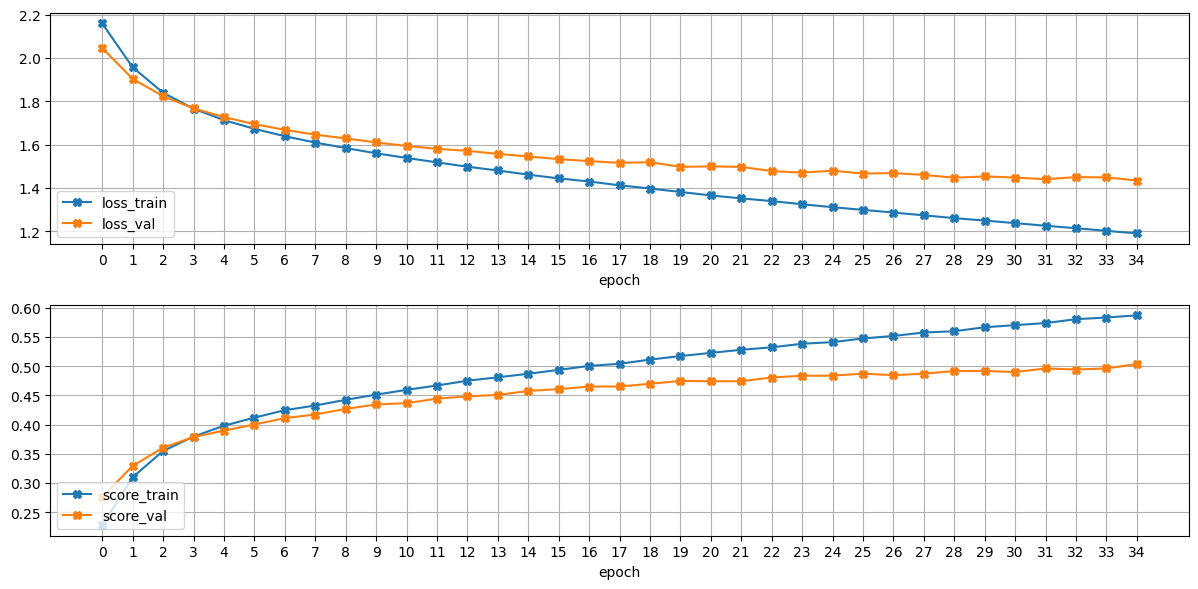

In [ ]:
pp_old.display([["loss_train", "loss_val"], ["score_train", "score_val"]])

Оцените точность на **тестовом** датасете (`testset`).

1. Добавьте в тестовый Dataset трансформацию, включающую в себя нормализацию.
2. Cоздайте DataLoader для тестовых данных.
3. Оцените точность с помощью функции `val_loop`.



In [ ]:
from torchvision import transforms

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

train_data.dataset.transform = transform_with_normalize
test_data.transform = transform_with_normalize

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")

NameError: name 'mean' is not defined

## Формат результата

1. Оценка точности на тестовых данных 0.48 .. 0.52
2. Суммарный график обучения. Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_3_task_ex05.png" width="800">

# Задание 4. Техники для работы в условиях дисбаланса классов

В этом задании вам предлагается решить задачу классификации на несбалансированном датасете [Car Evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation).

Требуется обучить полносвязную нейронную сеть, сделав бейзлайн с функцией потерь `CrossEntropyLoss`, а затем реализовать различные техники для работы в условиях дисбаланса:

1. `CrossEntropyLoss` **с весами для классов**,
2. `FocalLoss`,
3. `FocalLoss` **с весами для классов**,
4. `WeightedRandomSamlper` при функции потерь `CrossEntropyLoss`,
5. `WeightedRandomSamlper` при функции потерь `FocalLoss`,

сравнить их между собой и сделать выводы.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torch
import torchmetrics
import pandas as pd

from torch import nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Обзор датасета и подготовка данных для обучния

Загрузим датасет и взглянем на него:

In [ ]:
# !wget -qN https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/car_evaluation.zip
!unzip -qo car_evaluation.zip

In [ ]:
data = pd.read_csv(
    "car.data",
    names=["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"],
)

data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


В архиве найдем текстовый файл с описанием датасета `car.names`. Выведем его:

In [ ]:
!cat car.names

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:

   Car Evaluation Database was 

В датасете содержится 1728 наблюдений об автомобилях, которые описываются шестью категориальными признаками:
1. `buying` — стоимость покупки
2. `maint` — стоимость обслуживания
3. `doors` — количество дверей
4. `persons` — количество пассажиров
5. `lug_boot` — размер багажника
6. `safety` — оценка безопасности машины.

Также имеется целевой признак `class` с четырьмя уникальными значениями:

* `unacc` — неприемлемо
* `acc` — приемлемо
* `good` — хорошо
* `vgood` — отлично

Оценим баланс классов:

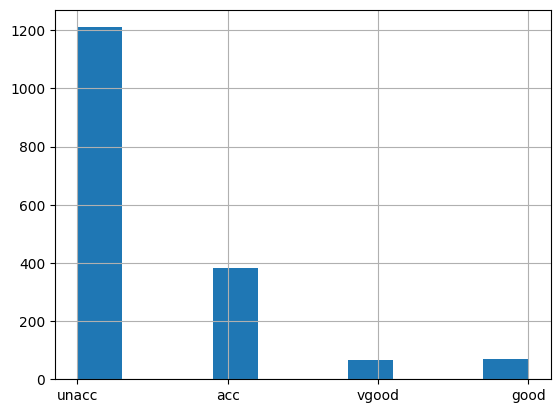

In [ ]:
data["class"].hist()
plt.show()

Посмотрим на описательные статистики по признакам:

In [ ]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


Все входные признаки в датасете — категориальные, поэтому предварительно нужно их закодировать. Воспользуемся [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)-ом для кодирования входных признаков.

In [ ]:
# split data to input x and target y
x, y = data.iloc[:, :-1], data.iloc[:, -1]

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

x_encoded = encoder.fit_transform(x)

x_encoded.shape

(1728, 21)

Классы просто закодируем порядковыми числами:

In [ ]:
classes = ["unacc", "acc", "good", "vgood"]
class_labels = [0, 1, 2, 3]
class_to_idx = dict(zip(classes, class_labels))
class_to_idx

{'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

In [ ]:
y_encoded = y.map(class_to_idx)  # mapping class names into their indexes
y_encoded = y_encoded.values  # transform Pandas Series into numpy array
y_encoded

array([0, 0, 0, ..., 0, 2, 3])

Разделим данные на обучающие и тестовые в соотношении 80/20 и переведем их в `torch.tensor`:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


Создадим `Dataset`-ы и `DataLoader`-ы для обучения нейросетей.

Обучающие и тестовые данные представляют из себя уже предобработанные тензоры. Поэтому для создания `Dataset`-ов можно воспользоваться классом [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [ ]:
trainset = torch.utils.data.TensorDataset(x_train, y_train)

testset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Напишите архитектуру полносвязной сети для этого датасета. Рекомендуется использовать 1–2 скрытых слоя из 5–10 нейронов.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(21, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 4),

        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)

        return logits



## Показатель качества при дисбалансе

Так как набор данных несбалансирован, оценивать качество модели по accuracy будет некорректно. В качетсве фукнции оценки можем выбрать F1-score. Его реализацию для удобства возьмем из [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f-1-score):

In [ ]:
score_function = torchmetrics.F1Score(task="multiclass", num_classes=4, average="macro")

## Бейзлайн c кросс-энтропией

Далее будет серия экспериментов по обучению нейросети на этом датасете с применением различных техник работы в условиях дисбаланса классов.
Для начала обучите бейзлайн с `CrossEntropyLoss`.

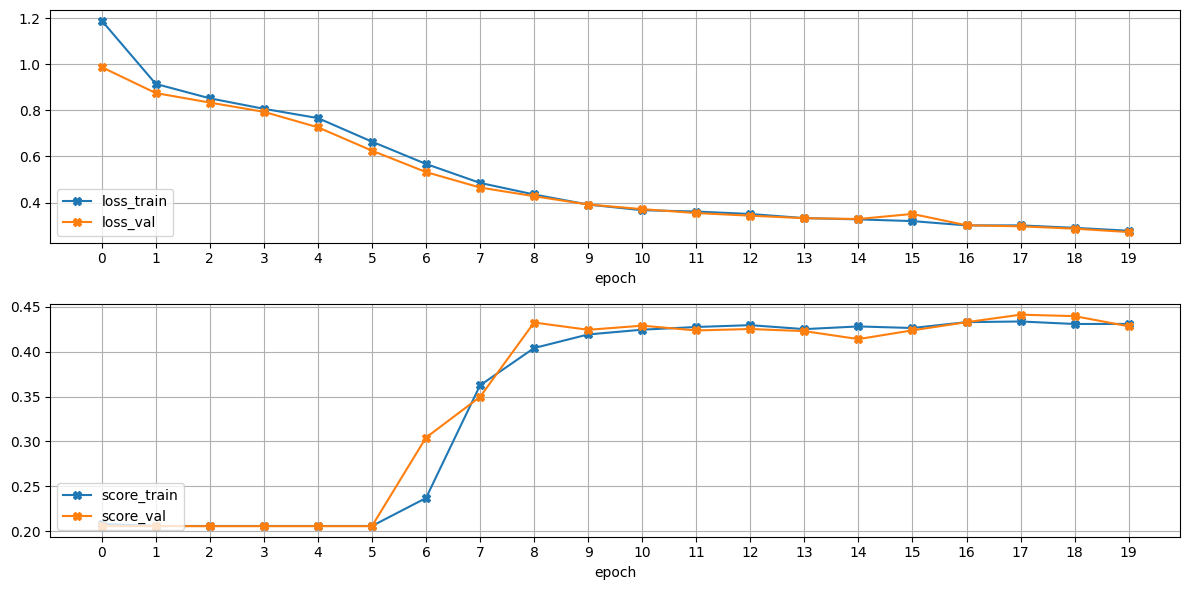

In [ ]:
set_random_seed(42)

model = Network().to(device)

criterion = torch.nn.CrossEntropyLoss() # Your code here

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Напишем функцию для прогона DataLoader-a через модель и получения предсказаний.

In [ ]:
def get_true_and_pred(dataloader, model):
    y_true, y_pred = [], []

    for input, target in dataloader:
        y_true.append(target)
        output = model(input.to(device))
        output = torch.argmax(output.cpu().detach(), dim=1)
        y_pred.append(output)

    y_true = np.array(torch.cat(y_true))
    y_pred = np.array(torch.cat(y_pred))

    return y_true, y_pred

Выведем отчет о качестве классификации тестовой выборки с помощью [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html):

In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.95      0.98      0.97       242
         acc       0.67      0.84      0.75        77
        good       0.00      0.00      0.00        14
       vgood       0.00      0.00      0.00        13

    accuracy                           0.87       346
   macro avg       0.41      0.46      0.43       346
weighted avg       0.81      0.87      0.84       346



Также посмотрим на матрицу ошибок ([`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Отобразим ее с помощью [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

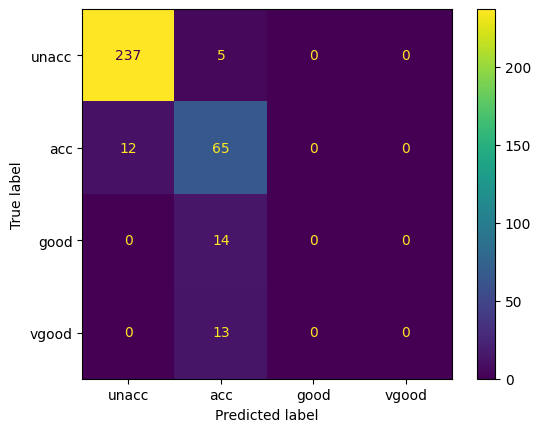

test_loss:0.27211149307814514, test_score:0.42812579870224


In [ ]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")

Опишите результаты классификации. Какие проблемы вы наблюдаете?

есть большое количество верных предсказаний для класса unacc, а для классов vgood/good все очень плохо (f1 - 0.87, но по гистограмме понятно, что назвать обучение успешным нельзя)

## Кросс-энтропия с весами для классов

Вам нужно создать одномерный тензор `weights_for_classes` с весами для классов. В качестве весов можно взять величины, обратные к количеству объектов определенного класса в обучающей выборке.

**Обратите внимание**, тензор с весами `weights_for_classes` должен быть перенесен на `device`.

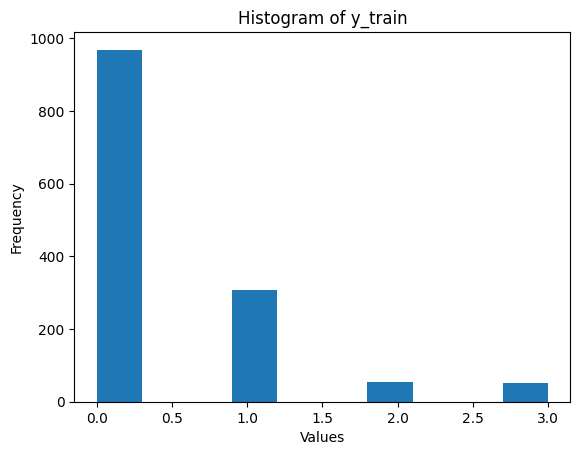

Класс 0: 968 объектов
Класс 1: 307 объектов
Класс 2: 55 объектов
Класс 3: 52 объектов


In [ ]:
import matplotlib.pyplot as plt
import torch


y_train_np = y_train.numpy()


plt.hist(y_train_np, bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of y_train')
plt.show()

y_train_list = y_train.tolist()

class_counts = torch.bincount(torch.tensor(y_train_list))

for class_idx, count in enumerate(class_counts):
    print(f'Класс {class_idx}: {count} объектов')

In [ ]:
_, classes_counts = torch.unique(y_train, return_counts=True)
weights_for_classes = classes_counts.max() / classes_counts
print(weights_for_classes)

# trainset = torch.utils.data.TensorDataset(x_train, y_train)

# testset = torch.utils.data.TensorDataset(x_test, y_test)

# train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

tensor([ 1.0000,  3.1531, 17.6000, 18.6154])


In [ ]:
from torch.utils.data import WeightedRandomSampler

weight_for_every_sample = []  # Every sample must have a weight
for label in y_train:
    weight_for_every_sample.append(weights_for_classes[label].item())

sampler = WeightedRandomSampler(torch.tensor(weight_for_every_sample), len(trainset))
dataloader = DataLoader(trainset, batch_size=batch_size, sampler=sampler)


Обучите модель с `CrossEntropyLoss`, передав ей в качестве аргумента `weight` тензор `weights_for_classes`.

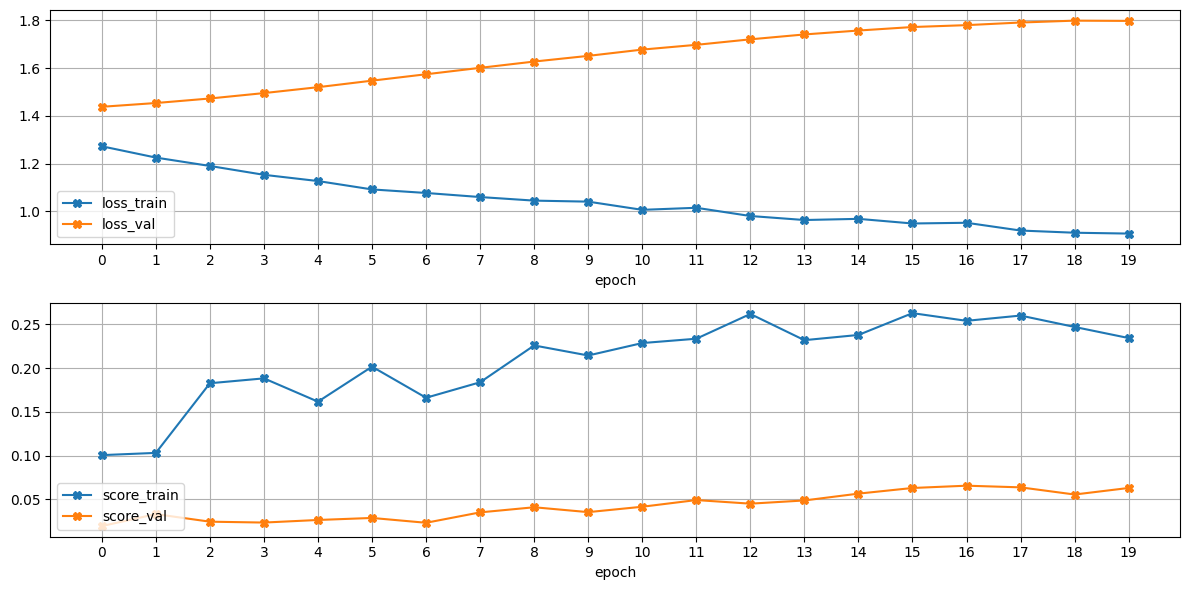

In [ ]:
set_random_seed(42)

model = Network().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights_for_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, dataloader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество обработки тестовой выборки с помощью отчета о классификации и матрицы ошибок.

In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.00      0.00      0.00       242
         acc       0.00      0.00      0.00        77
        good       0.03      0.43      0.05        14
       vgood       0.11      1.00      0.20        13

    accuracy                           0.05       346
   macro avg       0.03      0.36      0.06       346
weighted avg       0.01      0.05      0.01       346



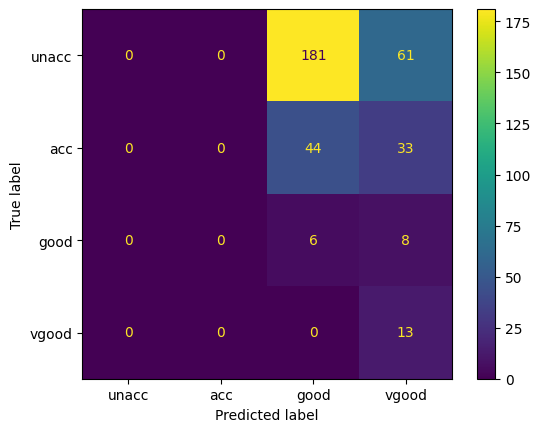

test_loss:1.7979713895104148, test_score:0.06302614510059357
test_loss:1.7979713895104148, test_score:0.06302614510059357


In [ ]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")

качество ухудшилось(теперь f1 - вообще практически нулевое), но при этом правильные ответы теперь возникают на других классах - которые практически не представлены в выборке

## Focal Loss

Воспользуйтесь Focal Loss в качестве функции потерь подобно тому, как вы сделали в бейзлайне с кросс-энтропией.

В этом пункте **не используйте** веса для классов. Параметр $\gamma$ примите равным $2$.

In [ ]:
#!wget -qN https://raw.githubusercontent.com/AdeelH/pytorch-multi-class-focal-loss/master/focal_loss.py
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX05/focal_loss.py

Информация из [документации](https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py):

* `alpha` (*Tensor*, optional): Weights for each class. Defaults to `None`.
* `gamma` (*float*, optional): A constant, as described in the paper. Defaults to `0`.
* `reduction` (*str*, optional): `'mean'`, `'sum'` or `'none'`. Defaults to `'mean'`.
* `ignore_index` (*int*, optional): class label to ignore. Defaults to `-100`.

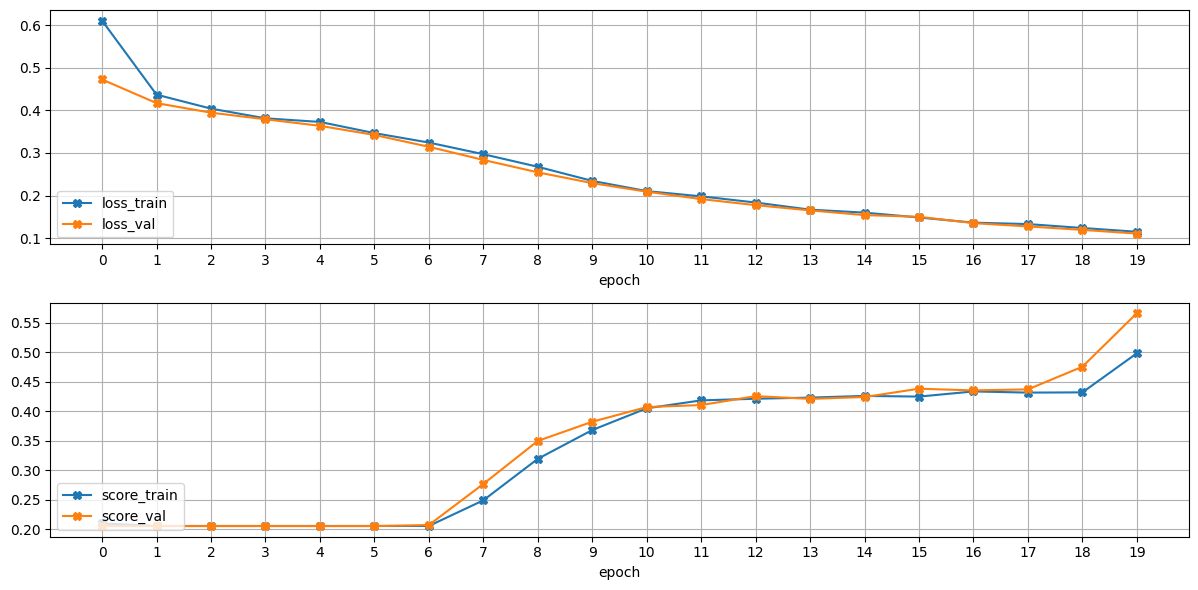

In [ ]:
from focal_loss import FocalLoss


set_random_seed(42)

model = Network().to(device)

criterion = FocalLoss(alpha=None, gamma=2.0)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.95      0.98      0.97       242
         acc       0.71      0.84      0.77        77
        good       0.00      0.00      0.00        14
       vgood       0.83      0.38      0.53        13

    accuracy                           0.89       346
   macro avg       0.62      0.55      0.57       346
weighted avg       0.86      0.89      0.87       346



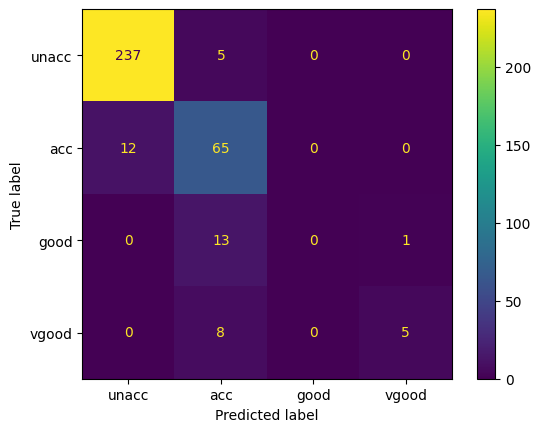

test_loss:0.11075801876458255, test_score:0.5663754940032959


In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")


теперь качество улучшилось по сравнению с прошлыми разом - при этом появились правильные предсказания для всех классов, что важно (не просто увеличилась f1)

## Focal Loss с весами для классов

Обучите модель с Focal Loss, передав ей в качестве парамета `alpha` тензор весов `weights_for_classes`. Как и в прошлом пункте, используйте $\gamma=2$.

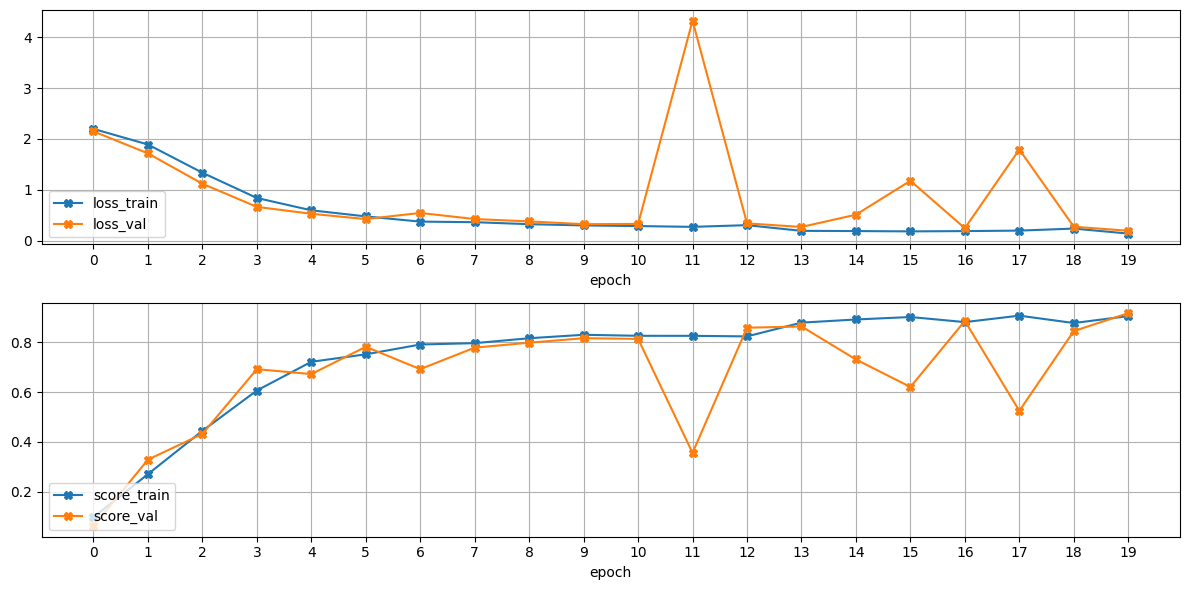

In [ ]:
set_random_seed(42)

model = Network().to(device)

criterion = FocalLoss(alpha=weights_for_classes, gamma=2.0)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.98      0.98      0.98       242
         acc       0.92      0.90      0.91        77
        good       0.92      0.86      0.89        14
       vgood       0.81      1.00      0.90        13

    accuracy                           0.95       346
   macro avg       0.91      0.93      0.92       346
weighted avg       0.95      0.95      0.95       346



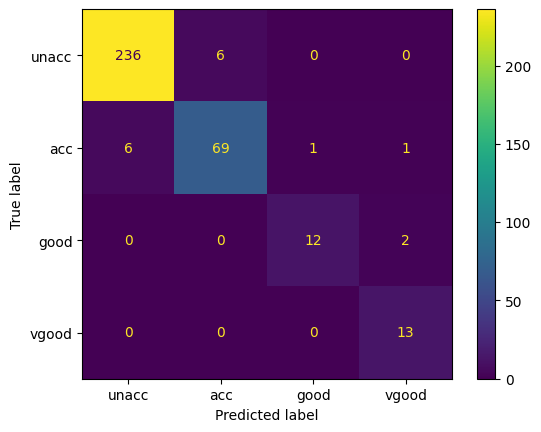

test_loss:0.19325130026448856, test_score:0.91713547706604


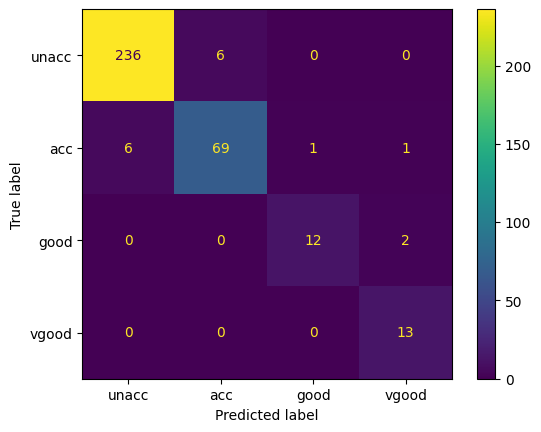

test_loss:0.19325130026448856, test_score:0.91713547706604


In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")



cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")


Опишите, как изменилось качество классификации.

качество сильно возросло  - метрика f1 вообще 0.95 - при это есть большое количество верных предсказаний для всех классов, пока лучший результат

## Weighted Random Sampler + Cross-Entropy Loss

Балансировать классы с помощью весов можно не только указывая их в функции потерь, но также и при формировании батчей.

Weighted Random Sampler занимается тем, что при формировании батчей учитывает веса разных объектов. Тем самым мы получаем возможность показывать модели объекты минорных классов чаще.

Особенность работы с Weighted Random Sampler в том, что ему нужно передать **веса для каждого объекта** в соответствии с тем, к какому классу этот объект относится. Создайте такой тензор весов `weight_for_every_sample`.

In [ ]:
from torch.utils.data import WeightedRandomSampler

y1 = torch.tensor(y_encoded)

_, classes_counts = torch.unique(y_train, return_counts=True)  # y — tensor of labels in train set
weights_for_classes = classes_counts.max() / classes_counts

weight_for_every_sample = []  # Every sample must have a weight
for label in y_train:
    weight_for_every_sample.append(weights_for_classes[label].item())

Теперь нужно создать `sampler`.

`WeightedRandomSampler`-у при инициализации нужно передать массив весов для каждого объекта, а также параметр `num_samples` — количество объектов для выдачи за одну эпоху. Этот параметр можно принять равным длине обучающей выборки.

Далее нужно заново создать обучающий `DataLoader`, и передать ему взвешенный `sampler`.

In [ ]:
trainset = torch.utils.data.TensorDataset(x_train, y_train)
testset = torch.utils.data.TensorDataset(x_test, y_test)

print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))


sampler = WeightedRandomSampler(torch.tensor(weight_for_every_sample), len(y_train))

1382
1382
346
346


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=sampler, drop_last=True)# Your code here
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Обучите модель с Cross-Entropy Loss **без весов для классов**, используя созданный выше `DataLoader` со взвешенным сэмплером. Обратите внимание, что мы уже учли дисбаланс во взвешенном сэмплере, поэтому указывать веса в функции потерь не нужно.

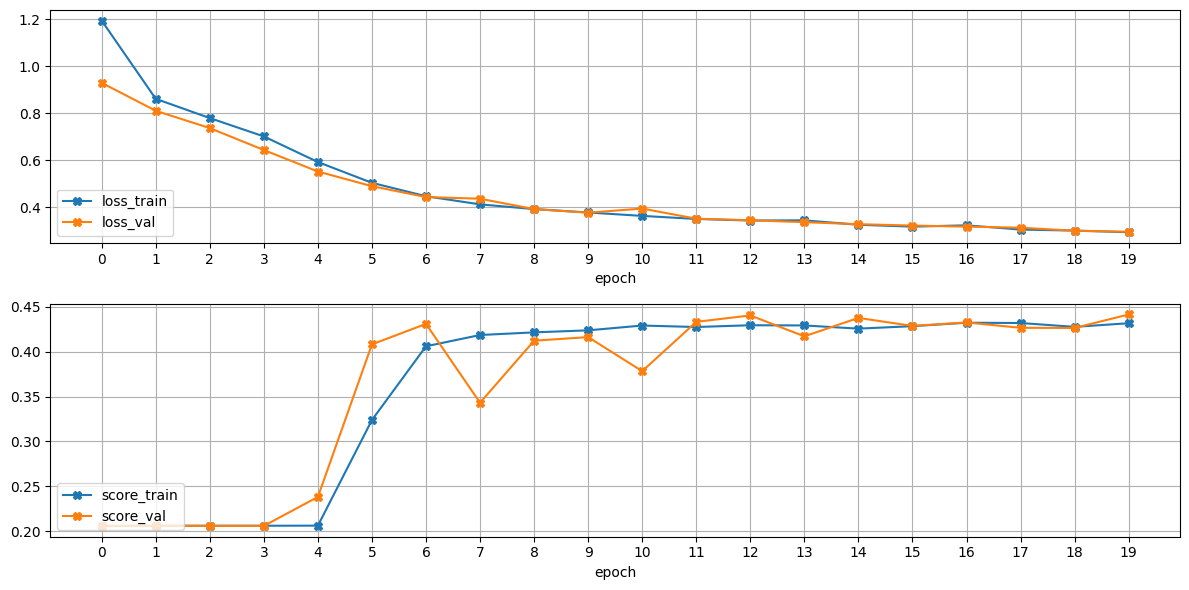

In [ ]:
model = Network().to(device)

criterion = torch.nn.CrossEntropyLoss()# Your code here

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.99      0.96      0.97       242
         acc       0.67      0.96      0.79        77
        good       0.00      0.00      0.00        14
       vgood       0.00      0.00      0.00        13

    accuracy                           0.89       346
   macro avg       0.42      0.48      0.44       346
weighted avg       0.84      0.89      0.86       346



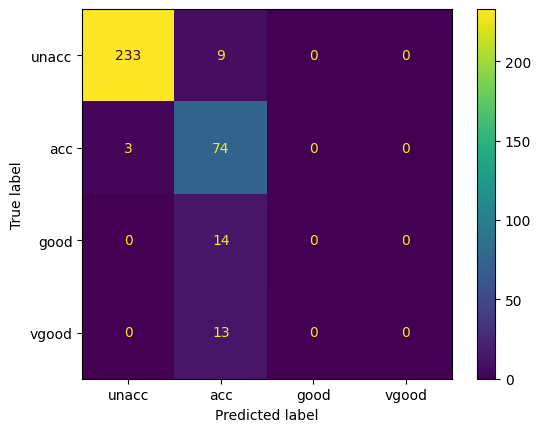

test_loss:0.2967274622483687, test_score:0.44158482551574707


In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")

f1 ухудшилось, при этом для двух последних классов отсутствуют верные предсказания, что плохо

***Your text here***

## Weighted Random Sampler + Focal Loss

Повторите обучение с Focal Loss, используя уже созданный `DataLoader` со взвешенным сэмплером.

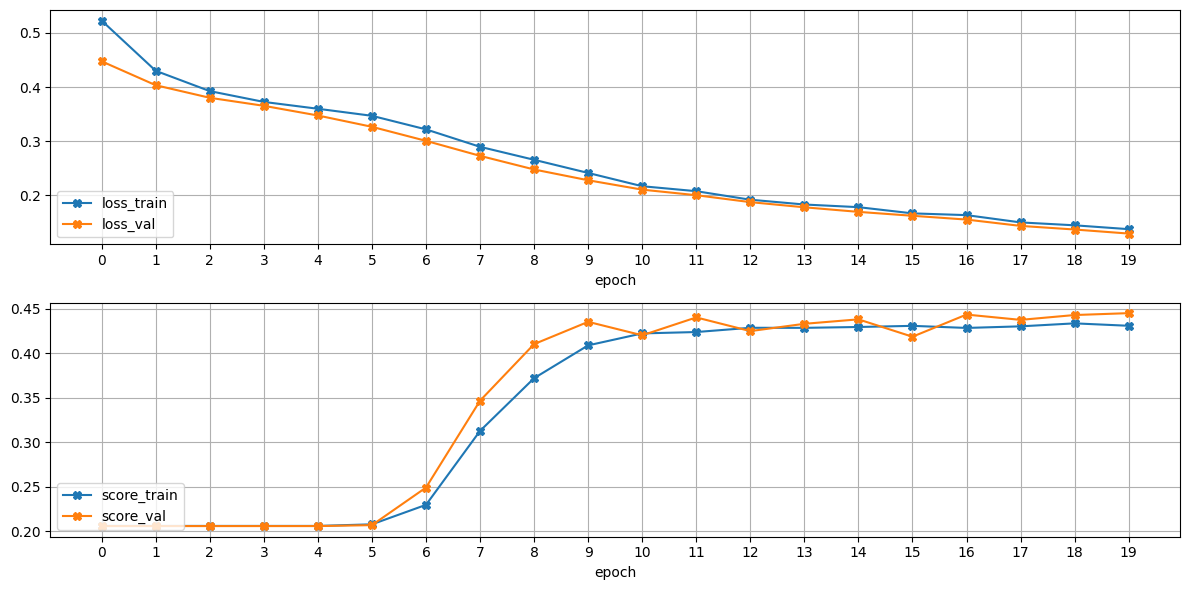

In [ ]:
model = Network().to(device)

criterion = FocalLoss(alpha=None, gamma=2.0)# Your code here

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.99      0.97      0.98       242
         acc       0.68      0.97      0.80        77
        good       0.00      0.00      0.00        14
       vgood       0.00      0.00      0.00        13

    accuracy                           0.89       346
   macro avg       0.42      0.49      0.45       346
weighted avg       0.85      0.89      0.86       346



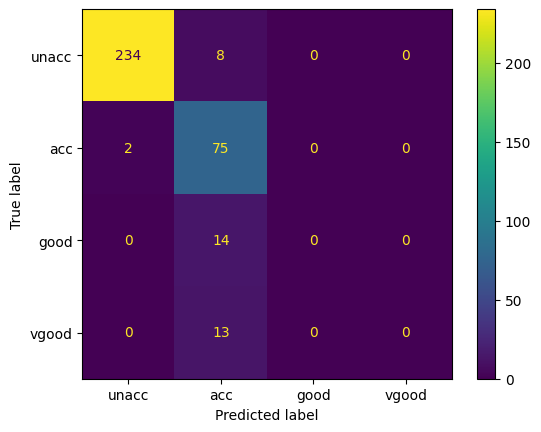

test_loss:0.12956415861845016, test_score:0.44530463218688965


In [ ]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

print(f"test_loss:{test_loss}, test_score:{test_score}")

f1 метрика увеличилась, при этом все так же не появились правильный предсказания для последних двух классов.

#Финальное обсуждение#
В целом я для каждой модели описывал изменение f1(метрика лучше всего подходит для дисбалансных классов) - лучше всего себя показал Focal Loss с весами для классов. Тут и самая высокая f1, но что самое важное - хорошие показатели предсказаний для ВСЕХ классов.

## Сравнение результатов

Сравните результаты классификации тестовой выборки при обучении моделей с разными техниками борьбы с дисбалансом. В качестве меры сравнения можно выбрать *macro F-1 score*, который выводится в `classification_report`.

## Формат результата

Результатом выполнения задания является обучение модели с шестью техниками:
0. Бейзлайн с кросс-энтропией
1. Кросс-энтропия с весами для классов
2. Focal Loss
3. Focal Loss с весами для классов
4. Weighted Random Sampler + кросс-энтропия
5. Weighted Random Sampler + Focal Loss

Для каждого обучения требуется вывести отчет о качестве классификации тестовой выборки и матрицу ошибок.
В конце требуется сравнить качество классификации по метрике *macro F-1 score*.